In [1]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import os, glob, re, random, time
from functools import partial
from pathlib import Path
import imageio
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import cmp_to_key

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from sklearn.metrics import roc_auc_score

from efficientnet_pytorch_3d import EfficientNet3D
import seaborn as sns

In [2]:
class Config():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists(), f'{base_path} does not exist'
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    png_folder = 'png'
    num_images = 32
    size = 256
    seed = 42
    test_size = 0.1
    clahe = False
    batch_size = 8
    num_workers = 7
    lr = 1e-3
    epochs = 20
    extra_check_epochs = [8]
    check_frequency = 4
    
cfg = Config()

### Function for loading images

In [3]:
def load_dicom(path):
    # read file
    dicom = pydicom.read_file(path)
    # get pixel data into a useful format. 
    data = dicom.pixel_array
    # transform data into black and white scale / grayscale
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data


def convert_dicom_to_png(path, png_image_path, resize = None, threshold=15):
    dicom = pydicom.read_file(path)
    data = apply_voi_lut(dicom.pixel_array, dicom)
    # If Resize == True, Resize Image to Specified Resolution
    if resize:
        data = cv2.resize(data, resize)
    # Transform Data as Necessary     
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    if np.mean(data) <= threshold:
        return 0
    # SAVE PNG TO DISK     
    imageio.imsave(png_image_path, data)
    return 1

### Loading data frames

In [4]:
train_df = pd.read_csv(cfg.base_path/'train_labels.csv')
train_df = train_df.drop(train_df[train_df['BraTS21ID'].isin([109, 123, 709])].index)
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [5]:
def convert_all_dicom_to_png(df, mri_type = 'FLAIR', image_path = 'train'):
    min_conversions = np.inf
    for scan_id in tqdm(df['BraTS21ID'], total=len(df)):
        dir_name = str(scan_id).zfill(5)
        png_dir = cfg.base_path/cfg.png_folder/image_path/dir_name/mri_type
        if not png_dir.exists():
            png_dir.mkdir(parents=True)
        source_dir = ((cfg.base_path/image_path)/dir_name)
        assert source_dir.exists()
        files = glob.glob(f"{str(source_dir/mri_type)}/*.dcm")
        print(f'Processing {png_dir}')
        conversions_sum = 0
        for f in files:
            f_name = re.sub(r'.+/(.+)\.dcm', r'\1.png', f)
            png_file = png_dir/f_name
            conversions_sum += convert_dicom_to_png(f, png_file, resize=(256,256))
        if min_conversions > conversions_sum:
            min_conversions = conversions_sum
            print('Min conversion', min_conversions)
    return min_conversions

In [6]:
submission_df = pd.read_csv(cfg.base_path/'sample_submission.csv')
submission_df

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


## Transform to png
Comment out if not needed

In [7]:
!rm -rf {cfg.base_path/cfg.png_folder}
if not (cfg.base_path/cfg.png_folder).exists():
    os.mkdir(cfg.base_path/cfg.png_folder)
convert_all_dicom_to_png(train_df, mri_type='FLAIR', image_path='train')

Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00000/FLAIR
Min conversion 159
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00002/FLAIR
Min conversion 53
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00003/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00005/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00006/FLAIR
Min conversion 50
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00008/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00009/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00011/FLAIR
Min conversion 49
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00012/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00014/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00017/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00018/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/train/00019/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/da

10

In [8]:
convert_all_dicom_to_png(submission_df, mri_type='FLAIR', image_path='test')

Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00001/FLAIR
Min conversion 79
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00013/FLAIR
Min conversion 52
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00015/FLAIR
Min conversion 46
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00027/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00037/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00047/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00079/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00080/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00082/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00091/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00114/FLAIR
Min conversion 15
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00119/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00125/FLAIR
Processing /home/RSNA_MICCAI_Brain_Tumor/data/png/test/00

13

In [9]:
!cp -R {cfg.base_path}/png/test/00013 {cfg.base_path}/png/train/00013
!cp -R {cfg.base_path}/png/test/00001 {cfg.base_path}/png/train/00001

### Load PNGs

In [10]:
def read_png(path):
    return mpimg.imread(path)

def convert_path_to_int(x):
    res = int(re.sub(r'.+\-+(\d+)\..+', r'\1', x))
    return res

def load_png_images_3d(scan_id, num_imgs=cfg.num_images, img_size=cfg.size, mri_type="FLAIR", split="train", clahe=False):

    glob_expr = f'{cfg.base_path}/png/{split}/{scan_id}/{mri_type}/*.png'
    files = glob.glob(glob_expr)
    files.sort(key=cmp_to_key(lambda x, y: -1 if convert_path_to_int(x) < convert_path_to_int(y) else 1))
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    try:
        img3d = np.stack([read_png(f) for f in files[p1:p2]]).T 
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d,  n_zero), axis = -1)
    except Exception as e:
        print(f'Error on glob expression', glob_expr)
        raise e
            
    return np.expand_dims(img3d,0)

(-0.5, 255.5, 255.5, -0.5)

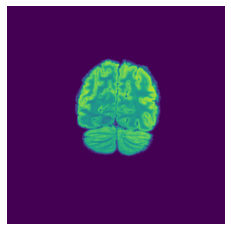

In [11]:
sample_img = read_png(cfg.base_path/'png/train/00000/FLAIR/Image-100.png')
plt.imshow(sample_img)
plt.axis('off')

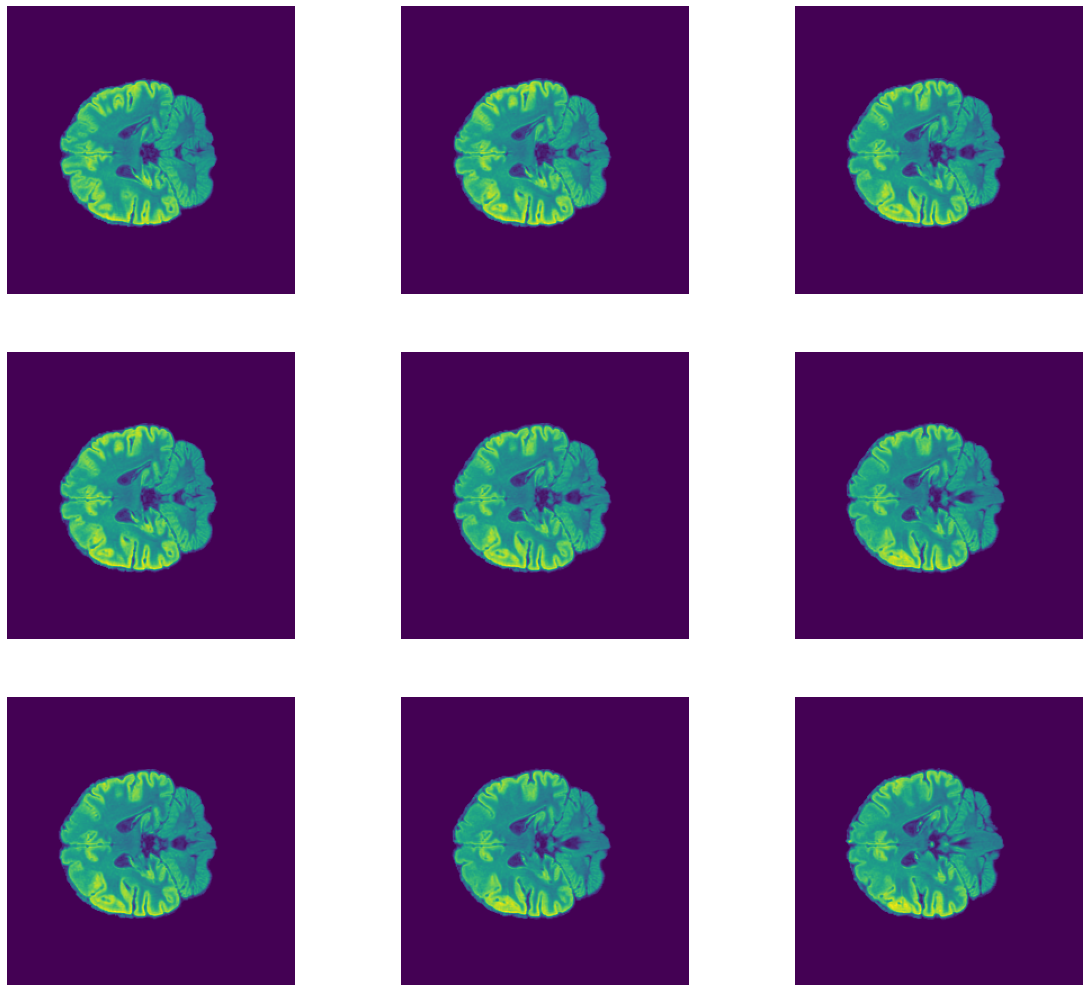

In [12]:
sample_images = load_png_images_3d('00000').squeeze()
f, axarr = plt.subplots(3, 3, figsize=(20, 18))
for r in range(3):
    for c in range(3):
        axarr[r, c].imshow(sample_images[:,:,r * 2 + c * 2])
        axarr[r, c].axis('off')

### Seeding

In [13]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### Train / Test Split

In [14]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=cfg.test_size, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [15]:
len(df_valid) / len(df_train)

0.11281070745697896

In [16]:
df_valid = df_valid.append(pd.DataFrame([{'BraTS21ID': 1, 'MGMT_value': 1}, {'BraTS21ID': 13, 'MGMT_value': 1}]))

In [17]:
len(df_valid) / len(df_train)

0.11663479923518165

### Dataset

In [18]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        mri_type = self.mri_type[index]
        if self.targets is None:
            data = load_png_images_3d(str(scan_id).zfill(5), mri_type=mri_type, split=self.split, clahe=cfg.clahe)
        else:
            data = load_png_images_3d(str(scan_id).zfill(5), mri_type=mri_type, split="train", clahe=cfg.clahe)
        data = np.moveaxis(data, -1, 1)
        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [19]:
df_train.loc[:,"MRI_Type"] = 'FLAIR'
sample_ds = Dataset(df_train['BraTS21ID'], df_train['MGMT_value'], df_train['MRI_Type'])

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [20]:
sample_ds[0]['X'].shape

torch.Size([1, 32, 256, 256])

### Model

In [21]:
class ModelHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self._fc = nn.Linear(in_features=in_features, out_features=hidden_dim, bias=True)
        self._fc_2 = nn.Linear(in_features=hidden_dim, out_features=1, bias=True)
        
    def forward(self, x):
        x = self._fc(x)
        x = self._fc_2(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = ModelHead(n_features, 600)
        
    
    def forward(self, x):
        x = torch.cat([x, x], axis=2)
        out = self.net(x)
        return out
    

In [22]:
def create_model():
    model = Model()
    model.to(cfg.device)
    return model

In [23]:
# sample_data = torch.randn([4, 1, 32, 256, 256]).to(cfg.device)
# torch.cat([sample_data, sample_data], axis=2).shape
# conv32_64 = nn.Conv3d(1, 1, kernel_size=1, stride=1, bias=False).to(cfg.device)
# m = nn.ConvTranspose3d(1, 1, 2, stride=2)
# input = torch.randn([4, 1, 32, 256, 256])
# m(input).shape

In [24]:
# sample_model = CustomModel()
# sample_model.to(cfg.device)
# torch.backends.cudnn.enabled = False
# sample_data = torch.randn([4, 1, 64, 256, 256]).to(cfg.device)
# sample_model(sample_data).shape

### Trainer

In [25]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = -np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
#         self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader) / 2), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lr_sched = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            train_loss, train_time = self.train_epoch(train_loader, valid_loader, n_epoch, save_path)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
            self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
        
    def check_and_save(self, valid_loss, valid_auc, valid_time, n_epoch, save_path):
        # if True:
        # if self.best_valid_score < valid_auc: 
        if self.best_valid_score < valid_auc and valid_auc > 0.5: 
            self.save_model(n_epoch, save_path, valid_loss, valid_auc)
            self.info_message(
                 "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                self.best_valid_score, valid_auc, self.lastmodel
            )
            self.best_valid_score = valid_auc
            self.n_patience = 0
        else:
            self.n_patience += 1
            
    def print_valid_message(self, valid_loss, valid_auc, valid_time, n_epoch):
        self.info_message(
            "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
            n_epoch, valid_loss, valid_auc, valid_time
        )
            
    def train_epoch(self, train_loader, valid_loader, n_epoch, save_path):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        scaler = torch.cuda.amp.GradScaler() # fp16
        for step, batch in tbar:
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                
#             loss.backward()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

            sum_loss += loss.detach().item()
#             torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
#             self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
            if n_epoch in cfg.extra_check_epochs:
                if step % cfg.check_frequency == 0:
                    valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                    self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
                    self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = torch.sigmoid(self.model(X).squeeze(1))
                loss = self.criterion(outputs, targets)
                print('outputs', outputs.mean().item(), outputs.std().item())
                print('targets', targets.mean().item(), targets.std().item())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [26]:
def loss_func(input, target):
#     return F.binary_cross_entropy_with_logits(input, target) * 0.5 + F.mse_loss(input, target) * 0.5
#     return F.binary_cross_entropy_with_logits(input, target) * 0.2 + dice_loss(input, target) * 0.8
    return F.binary_cross_entropy_with_logits(input, target)

In [27]:
def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = create_model()

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = loss_func

    trainer = Trainer(
        model, 
        cfg.device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs + 100,
    )
    
    return trainer.lastmodel

In [28]:
!rm -rf {str(cfg.models_path)}/*.pth

(523, 3) (61, 3)


,BraTS21ID,MGMT_value,MRI_Type
549,803,0,FLAIR
353,520,1,FLAIR
272,399,0,FLAIR
137,206,0,FLAIR
292,423,0,FLAIR


EPOCH: 1


Train Step 66/66, train_loss: 0.7299


outputs 0.5060909390449524 0.0
targets 0.5 0.5238320827484131
outputs 0.5060909390449524 0.07248
targets 0.6225000023841858 0.5071982145309448
outputs 0.5060909390449524 0.06938
targets 0.5 0.5238320827484131
outputs 0.5060909390449524 0.07042
targets 0.6225000023841858 0.5071982145309448
outputs 0.5060909390449524 0.06938
targets 0.3774999976158142 0.5071982145309448
outputs 0.5060909390449524 0.07124
targets 0.3774999976158142 0.5071982145309448
outputs 0.5060909390449524 0.07248
targets 0.6225000023841858 0.5071982145309448
outputs 0.5060909390449524 0.07160
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6985
[Epoch Train: 1] loss: 0.7299, time: 50.00 s            
[Epoch Valid: 1] loss: 0.6985, auc: 0.5000, time: 3.00 s
EPOCH: 2


Train Step 66/66, train_loss: 0.7033


outputs 0.5104498863220215 0.0
targets 0.5 0.5238320827484131
outputs 0.5104498863220215 0.07254
targets 0.6225000023841858 0.5071982145309448
outputs 0.5104498863220215 0.06941
targets 0.5 0.5238320827484131
outputs 0.5104498863220215 0.07045
targets 0.6225000023841858 0.5071982145309448
outputs 0.5104498863220215 0.06941
targets 0.3774999976158142 0.5071982145309448
outputs 0.5104498863220215 0.07129
targets 0.3774999976158142 0.5071982145309448
outputs 0.5104498863220215 0.07254
targets 0.6225000023841858 0.5071982145309448
outputs 0.5104498863220215 0.07164
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6988
[Epoch Train: 2] loss: 0.7033, time: 49.00 s            
[Epoch Valid: 2] loss: 0.6988, auc: 0.5000, time: 3.00 s
EPOCH: 3


Train Step 66/66, train_loss: 0.7227


outputs 0.5327075719833374 0.0
targets 0.5 0.5238320827484131
outputs 0.5327075719833374 0.07282
targets 0.6225000023841858 0.5071982145309448
outputs 0.5327075719833374 0.06956
targets 0.5 0.5238320827484131
outputs 0.5327075719833374 0.07065
targets 0.6225000023841858 0.5071982145309448
outputs 0.5327075719833374 0.06956
targets 0.3774999976158142 0.5071982145309448
outputs 0.5327075719833374 0.07152
targets 0.3774999976158142 0.5071982145309448
outputs 0.5327075719833374 0.07282
targets 0.6225000023841858 0.5071982145309448
outputs 0.5327076315879822 0.07189
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7005
[Epoch Train: 3] loss: 0.7227, time: 49.00 s            
[Epoch Valid: 3] loss: 0.7005, auc: 0.5000, time: 3.00 s
EPOCH: 4


Train Step 66/66, train_loss: 0.7238


outputs 0.47168248891830444 8.315709720818631e-08
targets 0.5 0.5238320827484131
outputs 0.47168248891830444 8.46691676770206e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.47168242931365967 3.379265578473678e-08
targets 0.5 0.5238320827484131
outputs 0.47168245911598206 8.083598146413351e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.4716823995113373 8.90514755269578e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.47168245911598206 7.763327403154108e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.47168242931365967 5.798611724117109e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.47168245911598206 8.924124728082461e-08
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6961
[Epoch Train: 4] loss: 0.7238, time: 49.00 s            
[Epoch Valid: 4] loss: 0.6961, auc: 0.4253, time: 3.00 s
EPOCH: 5


Train Step 66/66, train_loss: 0.7038


outputs 0.5350828766822815 1.111910250983783e-06
targets 0.5 0.5238320827484131
outputs 0.5350826978683472 1.1099685934823356e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5350825786590576 9.768098152562743e-07
targets 0.5 0.5238320827484131
outputs 0.535082221031189 1.5050278534545214e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5350823402404785 7.881734518377925e-07
targets 0.3774999976158142 0.5071982145309448
outputs 0.5350819230079651 6.664001830358757e-07
targets 0.3774999976158142 0.5071982145309448
outputs 0.5350823402404785 1.0057377721750527e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5350818634033203 2.046554072876461e-06
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7007
[Epoch Train: 5] loss: 0.7038, time: 49.00 s            
[Epoch Valid: 5] loss: 0.7007, auc: 0.4102, time: 3.00 s
EPOCH: 6


Train Step 66/66, train_loss: 0.6904


outputs 0.5431711673736572 0.000142559758387506
targets 0.5 0.5238320827484131
outputs 0.5431385636329651 0.00015217324835248291
targets 0.6225000023841858 0.5071982145309448
outputs 0.5431627631187439 0.00020461266103666276
targets 0.5 0.5238320827484131
outputs 0.5431908369064331 0.00020241453603375703
targets 0.6225000023841858 0.5071982145309448
outputs 0.5432788133621216 0.00017370845307596028
targets 0.3774999976158142 0.5071982145309448
outputs 0.5432332754135132 0.00020471330208238214
targets 0.3774999976158142 0.5071982145309448
outputs 0.5432013869285583 0.00023148863692767918
targets 0.6225000023841858 0.5071982145309448
outputs 0.543204665184021 0.0002726336242631078
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7013
[Epoch Train: 6] loss: 0.6904, time: 49.00 s            
[Epoch Valid: 6] loss: 0.7013, auc: 0.5422, time: 3.00 s
auc improved from -inf to 0.5422. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e6-loss0.701-auc0.542.p

Train Step 66/66, train_loss: 0.7024


outputs 0.5730744004249573 0.00436022412031889
targets 0.5 0.5238320827484131
outputs 0.5704848766326904 0.00709855230525136
targets 0.6225000023841858 0.5071982145309448
outputs 0.5718319416046143 0.0038711070083081722
targets 0.5 0.5238320827484131
outputs 0.5733031034469604 0.003676237538456917
targets 0.6225000023841858 0.5071982145309448
outputs 0.5720085501670837 0.008630928583443165
targets 0.3774999976158142 0.5071982145309448
outputs 0.5709866881370544 0.00638799462467432
targets 0.3774999976158142 0.5071982145309448
outputs 0.5740667581558228 0.004436303861439228
targets 0.6225000023841858 0.5071982145309448
outputs 0.5613858103752136 0.014461444690823555
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7038
[Epoch Train: 7] loss: 0.7024, time: 49.00 s            
[Epoch Valid: 7] loss: 0.7038, auc: 0.5390, time: 3.00 s
EPOCH: 8


outputs 0.49747174978256226 0.005796139128506184
targets 0.5 0.5238320827484131
outputs 0.4951162040233612 0.004128629807382822
targets 0.6225000023841858 0.5071982145309448
outputs 0.4983372688293457 0.0046419426798820496
targets 0.5 0.5238320827484131
outputs 0.49836504459381104 0.003909547813236713
targets 0.6225000023841858 0.5071982145309448
outputs 0.49721935391426086 0.007047794293612242
targets 0.3774999976158142 0.5071982145309448
outputs 0.4955735206604004 0.0045509496703743935
targets 0.3774999976158142 0.5071982145309448
outputs 0.49914276599884033 0.0037625108379870653
targets 0.6225000023841858 0.5071982145309448
outputs 0.4932694435119629 0.00937110185623169
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6975
auc improved from 0.5422 to 0.6136. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e8-loss0.697-auc0.614.pth'
[Epoch Valid: 8] loss: 0.6975, auc: 0.6136, time: 3.00 s


outputs 0.470571905374527 0.0008479248499497771
targets 0.5 0.5238320827484131
outputs 0.47070246934890747 0.0009645461104810238
targets 0.6225000023841858 0.5071982145309448
outputs 0.47074252367019653 0.0015007179463282228
targets 0.5 0.5238320827484131
outputs 0.4707299768924713 0.0017312145791947842
targets 0.6225000023841858 0.5071982145309448
outputs 0.47066637873649597 0.0012454161187633872
targets 0.3774999976158142 0.5071982145309448
outputs 0.470600962638855 0.001047288067638874
targets 0.3774999976158142 0.5071982145309448
outputs 0.47035619616508484 0.0005082535790279508
targets 0.6225000023841858 0.5071982145309448
outputs 0.4722575843334198 0.002819688757881522
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6961
[Epoch Valid: 8] loss: 0.6961, auc: 0.4968, time: 3.00 s


outputs 0.4436720013618469 0.003910743165761232
targets 0.5 0.5238320827484131
outputs 0.44500863552093506 0.00399350980296731
targets 0.6225000023841858 0.5071982145309448
outputs 0.4435904622077942 0.002972258487716317
targets 0.5 0.5238320827484131
outputs 0.44384297728538513 0.0037994165904819965
targets 0.6225000023841858 0.5071982145309448
outputs 0.44460803270339966 0.005296857096254826
targets 0.3774999976158142 0.5071982145309448
outputs 0.44429004192352295 0.002870314521715045
targets 0.3774999976158142 0.5071982145309448
outputs 0.44268998503685 0.002266647992655635
targets 0.6225000023841858 0.5071982145309448
outputs 0.447998583316803 0.01002611592411995
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6948
[Epoch Valid: 8] loss: 0.6948, auc: 0.3853, time: 3.00 s


outputs 0.4956051707267761 0.006692021153867245
targets 0.5 0.5238320827484131
outputs 0.49817824363708496 0.006292961537837982
targets 0.6225000023841858 0.5071982145309448
outputs 0.49438953399658203 0.005670809652656317
targets 0.5 0.5238320827484131
outputs 0.49449464678764343 0.005518792197108269
targets 0.6225000023841858 0.5071982145309448
outputs 0.4962978959083557 0.008604612201452255
targets 0.3774999976158142 0.5071982145309448
outputs 0.4970689117908478 0.005629686173051596
targets 0.3774999976158142 0.5071982145309448
outputs 0.4936854839324951 0.005407220218330622
targets 0.6225000023841858 0.5071982145309448
outputs 0.4987269937992096 0.01191397849470377
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6984
[Epoch Valid: 8] loss: 0.6984, auc: 0.3755, time: 3.00 s


outputs 0.5231313705444336 0.003680095775052905
targets 0.5 0.5238320827484131
outputs 0.5245852470397949 0.0035669554490596056
targets 0.6225000023841858 0.5071982145309448
outputs 0.5219254493713379 0.004615245386958122
targets 0.5 0.5238320827484131
outputs 0.5218376517295837 0.005941833835095167
targets 0.6225000023841858 0.5071982145309448
outputs 0.523019552230835 0.004824404139071703
targets 0.3774999976158142 0.5071982145309448
outputs 0.523901641368866 0.004367873538285494
targets 0.3774999976158142 0.5071982145309448
outputs 0.5218003392219543 0.004303569905459881
targets 0.6225000023841858 0.5071982145309448
outputs 0.5230989456176758 0.00512976897880435
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7001
[Epoch Valid: 8] loss: 0.7001, auc: 0.3766, time: 3.00 s


outputs 0.517187237739563 0.0014203384052962065
targets 0.5 0.5238320827484131
outputs 0.517776370048523 0.0013949052663519979
targets 0.6225000023841858 0.5071982145309448
outputs 0.5166149735450745 0.0021253267768770456
targets 0.5 0.5238320827484131
outputs 0.5165914297103882 0.0030790790915489197
targets 0.6225000023841858 0.5071982145309448
outputs 0.5168187618255615 0.0019194937776774168
targets 0.3774999976158142 0.5071982145309448
outputs 0.5174294114112854 0.0021291973534971476
targets 0.3774999976158142 0.5071982145309448
outputs 0.5165106058120728 0.002229441190138459
targets 0.6225000023841858 0.5071982145309448
outputs 0.5162752270698547 0.002043006243184209
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6995
[Epoch Valid: 8] loss: 0.6995, auc: 0.3528, time: 3.00 s


outputs 0.5099807381629944 0.004111632704734802
targets 0.5 0.5238320827484131
outputs 0.5087271928787231 0.0036596031859517097
targets 0.6225000023841858 0.5071982145309448
outputs 0.5103821754455566 0.002990078879520297
targets 0.5 0.5238320827484131
outputs 0.5107659101486206 0.0020655044354498386
targets 0.6225000023841858 0.5071982145309448
outputs 0.5087486505508423 0.0054015046916902065
targets 0.3774999976158142 0.5071982145309448
outputs 0.5087398886680603 0.0037466452922672033
targets 0.3774999976158142 0.5071982145309448
outputs 0.5108223557472229 0.002830235054716468
targets 0.6225000023841858 0.5071982145309448
outputs 0.5072615742683411 0.00856329221278429
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6985
[Epoch Valid: 8] loss: 0.6985, auc: 0.6136, time: 3.00 s


outputs 0.5154163837432861 0.014971572905778885
targets 0.5 0.5238320827484131
outputs 0.5109544992446899 0.013835187070071697
targets 0.6225000023841858 0.5071982145309448
outputs 0.5174432396888733 0.011509650386869907
targets 0.5 0.5238320827484131
outputs 0.5198373794555664 0.008396454155445099
targets 0.6225000023841858 0.5071982145309448
outputs 0.5113969445228577 0.020476898178458214
targets 0.3774999976158142 0.5071982145309448
outputs 0.5111156105995178 0.014552096836268902
targets 0.3774999976158142 0.5071982145309448
outputs 0.518949031829834 0.011470959521830082
targets 0.6225000023841858 0.5071982145309448
outputs 0.50657057762146 0.030459929257631302
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6982
auc improved from 0.6136 to 0.6201. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e8-loss0.698-auc0.620.pth'
[Epoch Valid: 8] loss: 0.6982, auc: 0.6201, time: 3.00 s


outputs 0.5670808553695679 0.006419739220291376
targets 0.5 0.5238320827484131
outputs 0.5624051690101624 0.00816513691097498
targets 0.6225000023841858 0.5071982145309448
outputs 0.5652714967727661 0.007549090310931206
targets 0.5 0.5238320827484131
outputs 0.5688897371292114 0.0058981855399906635
targets 0.6225000023841858 0.5071982145309448
outputs 0.5626134276390076 0.01474672555923462
targets 0.3774999976158142 0.5071982145309448
outputs 0.560436487197876 0.010427968576550484
targets 0.3774999976158142 0.5071982145309448
outputs 0.5674639344215393 0.005915150046348572
targets 0.6225000023841858 0.5071982145309448
outputs 0.5518190860748291 0.03790593892335892
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7029
[Epoch Valid: 8] loss: 0.7029, auc: 0.6093, time: 3.00 s


outputs 0.5068745017051697 0.017505494877696037
targets 0.5 0.5238320827484131
outputs 0.5084249377250671 0.014371836557984352
targets 0.6225000023841858 0.5071982145309448
outputs 0.5059986710548401 0.013182686641812325
targets 0.5 0.5238320827484131
outputs 0.49614983797073364 0.017809420824050903
targets 0.6225000023841858 0.5071982145309448
outputs 0.5083063840866089 0.024179404601454735
targets 0.3774999976158142 0.5071982145309448
outputs 0.5119599103927612 0.018741903826594353
targets 0.3774999976158142 0.5071982145309448
outputs 0.5060024261474609 0.023278042674064636
targets 0.6225000023841858 0.5071982145309448
outputs 0.516652524471283 0.0262193214148283
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6998
[Epoch Valid: 8] loss: 0.6998, auc: 0.4426, time: 3.00 s


outputs 0.5177724957466125 0.016056092455983162
targets 0.5 0.5238320827484131
outputs 0.5133813619613647 0.016243712976574898
targets 0.6225000023841858 0.5071982145309448
outputs 0.5150076746940613 0.01729653589427471
targets 0.5 0.5238320827484131
outputs 0.5089194774627686 0.024102969095110893
targets 0.6225000023841858 0.5071982145309448
outputs 0.5195878744125366 0.018026353791356087
targets 0.3774999976158142 0.5071982145309448
outputs 0.5193279981613159 0.011869500391185284
targets 0.3774999976158142 0.5071982145309448
outputs 0.5142421722412109 0.025542953982949257
targets 0.6225000023841858 0.5071982145309448
outputs 0.5204409956932068 0.01915515772998333
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6995
[Epoch Valid: 8] loss: 0.6995, auc: 0.4784, time: 3.00 s


outputs 0.34656089544296265 0.05488530546426773
targets 0.5 0.5238320827484131
outputs 0.34675395488739014 0.0640704408288002
targets 0.6225000023841858 0.5071982145309448
outputs 0.3670927882194519 0.05544039234519005
targets 0.5 0.5238320827484131
outputs 0.340808242559433 0.08205405622720718
targets 0.6225000023841858 0.5071982145309448
outputs 0.36738282442092896 0.059751350432634354
targets 0.3774999976158142 0.5071982145309448
outputs 0.38287895917892456 0.05017022415995598
targets 0.3774999976158142 0.5071982145309448
outputs 0.34684160351753235 0.08519852161407471
targets 0.6225000023841858 0.5071982145309448
outputs 0.36691123247146606 0.0649409070611
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6893
[Epoch Valid: 8] loss: 0.6893, auc: 0.5606, time: 3.00 s


outputs 0.5125704407691956 0.0013743456220254302
targets 0.5 0.5238320827484131
outputs 0.5130000114440918 0.0013559457147493958
targets 0.6225000023841858 0.5071982145309448
outputs 0.5130898356437683 0.0012952116085216403
targets 0.5 0.5238320827484131
outputs 0.5116086006164551 0.0010410599643364549
targets 0.6225000023841858 0.5071982145309448
outputs 0.5122551918029785 0.0018091954989358783
targets 0.3774999976158142 0.5071982145309448
outputs 0.5127242207527161 0.002014376688748598
targets 0.3774999976158142 0.5071982145309448
outputs 0.5126935243606567 0.0017084808787330985
targets 0.6225000023841858 0.5071982145309448
outputs 0.5129536986351013 0.0015146658988669515
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6990
[Epoch Valid: 8] loss: 0.6990, auc: 0.4697, time: 3.00 s


outputs 0.5142198801040649 0.00030951114604249597
targets 0.5 0.5238320827484131
outputs 0.5138070583343506 0.0005577317788265646
targets 0.6225000023841858 0.5071982145309448
outputs 0.5140426158905029 0.00045721721835434437
targets 0.5 0.5238320827484131
outputs 0.5144082307815552 0.0004370847891550511
targets 0.6225000023841858 0.5071982145309448
outputs 0.5141370892524719 0.0006076394347473979
targets 0.3774999976158142 0.5071982145309448
outputs 0.5139493942260742 0.0006687099230475724
targets 0.3774999976158142 0.5071982145309448
outputs 0.5140220522880554 0.000524778151884675
targets 0.6225000023841858 0.5071982145309448
outputs 0.5139753818511963 0.00038141111144796014
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6991
[Epoch Valid: 8] loss: 0.6991, auc: 0.4697, time: 3.00 s


outputs 0.5277033448219299 0.0031629016157239676
targets 0.5 0.5238320827484131
outputs 0.5226768851280212 0.008868616074323654
targets 0.6225000023841858 0.5071982145309448
outputs 0.52582848072052 0.0053014629520475864
targets 0.5 0.5238320827484131
outputs 0.5294139385223389 0.002864829497411847
targets 0.6225000023841858 0.5071982145309448
outputs 0.5282440185546875 0.0061665927059948444
targets 0.3774999976158142 0.5071982145309448
outputs 0.5210116505622864 0.01172559056431055
targets 0.3774999976158142 0.5071982145309448
outputs 0.5253581404685974 0.008635319769382477
targets 0.6225000023841858 0.5071982145309448
outputs 0.5238378643989563 0.004896130412817001
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6999
[Epoch Valid: 8] loss: 0.6999, auc: 0.4968, time: 3.00 s


outputs 0.5388166904449463 0.003922680392861366
targets 0.5 0.5238320827484131
outputs 0.5313517451286316 0.012490220367908478
targets 0.6225000023841858 0.5071982145309448
outputs 0.5362590551376343 0.0062782797031104565
targets 0.5 0.5238320827484131
outputs 0.5411391258239746 0.0031273155473172665
targets 0.6225000023841858 0.5071982145309448
outputs 0.5392162203788757 0.0074022687040269375
targets 0.3774999976158142 0.5071982145309448
outputs 0.5289176106452942 0.016452061012387276
targets 0.3774999976158142 0.5071982145309448
outputs 0.5349892377853394 0.0120439687743783
targets 0.6225000023841858 0.5071982145309448
outputs 0.5340554118156433 0.006600429303944111
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7005
[Epoch Valid: 8] loss: 0.7005, auc: 0.5216, time: 3.00 s
Train Step 66/66, train_loss: 0.7014


outputs 0.5401182770729065 0.003943286370486021
targets 0.5 0.5238320827484131
outputs 0.5328731536865234 0.012005318887531757
targets 0.6225000023841858 0.5071982145309448
outputs 0.5378135442733765 0.005606965161859989
targets 0.5 0.5238320827484131
outputs 0.5427781939506531 0.002456762595102191
targets 0.6225000023841858 0.5071982145309448
outputs 0.5404012203216553 0.006911551579833031
targets 0.3774999976158142 0.5071982145309448
outputs 0.530656099319458 0.015779975801706314
targets 0.3774999976158142 0.5071982145309448
outputs 0.5364925265312195 0.011370554566383362
targets 0.6225000023841858 0.5071982145309448
outputs 0.5367044806480408 0.005700675304979086
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7005
[Epoch Train: 8] loss: 0.7014, time: 106.00 s            
[Epoch Valid: 8] loss: 0.7005, auc: 0.5271, time: 3.00 s
EPOCH: 9


Train Step 66/66, train_loss: 0.6979


outputs 0.5024348497390747 0.0071664429269731045
targets 0.5 0.5238320827484131
outputs 0.503751814365387 0.005158540792763233
targets 0.6225000023841858 0.5071982145309448
outputs 0.5025505423545837 0.010077542625367641
targets 0.5 0.5238320827484131
outputs 0.5046837329864502 0.007348336279392242
targets 0.6225000023841858 0.5071982145309448
outputs 0.5032281279563904 0.0073300679214298725
targets 0.3774999976158142 0.5071982145309448
outputs 0.4991982579231262 0.007276494055986404
targets 0.3774999976158142 0.5071982145309448
outputs 0.5029059648513794 0.009584634564816952
targets 0.6225000023841858 0.5071982145309448
outputs 0.4968391954898834 0.012328287586569786
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6983
[Epoch Train: 9] loss: 0.6979, time: 49.00 s            
[Epoch Valid: 9] loss: 0.6983, auc: 0.5260, time: 3.00 s
EPOCH: 10


Train Step 66/66, train_loss: 0.6820


outputs 0.764594554901123 0.054787762463092804
targets 0.5 0.5238320827484131
outputs 0.6608542203903198 0.10526534169912338
targets 0.6225000023841858 0.5071982145309448
outputs 0.7674951553344727 0.06875748187303543
targets 0.5 0.5238320827484131
outputs 0.7229281663894653 0.09060933440923691
targets 0.6225000023841858 0.5071982145309448
outputs 0.6779478192329407 0.0980745479464531
targets 0.3774999976158142 0.5071982145309448
outputs 0.6824676990509033 0.15406078100204468
targets 0.3774999976158142 0.5071982145309448
outputs 0.7427159547805786 0.06438592821359634
targets 0.6225000023841858 0.5071982145309448
outputs 0.6173136830329895 0.1314878612756729
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7156
[Epoch Train: 10] loss: 0.6820, time: 49.00 s            
[Epoch Valid: 10] loss: 0.7156, auc: 0.4589, time: 3.00 s
EPOCH: 11


Train Step 66/66, train_loss: 0.6810


outputs 0.5036776065826416 0.0941789299249649
targets 0.5 0.5238320827484131
outputs 0.5228573083877563 0.11136630922555923
targets 0.6225000023841858 0.5071982145309448
outputs 0.4919126033782959 0.09237665683031082
targets 0.5 0.5238320827484131
outputs 0.537257730960846 0.09603606909513474
targets 0.6225000023841858 0.5071982145309448
outputs 0.5156697630882263 0.09065945446491241
targets 0.3774999976158142 0.5071982145309448
outputs 0.5778868198394775 0.032520655542612076
targets 0.3774999976158142 0.5071982145309448
outputs 0.43392258882522583 0.10535355657339096
targets 0.6225000023841858 0.5071982145309448
outputs 0.5029078125953674 0.08100442588329315
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6934
[Epoch Train: 11] loss: 0.6810, time: 49.00 s            
[Epoch Valid: 11] loss: 0.6934, auc: 0.6071, time: 3.00 s
EPOCH: 12


Train Step 66/66, train_loss: 0.6242


outputs 0.4987989664077759 0.33036836981773376
targets 0.5 0.5238320827484131
outputs 0.37184035778045654 0.28155821561813354
targets 0.6225000023841858 0.5071982145309448
outputs 0.38317739963531494 0.29768845438957214
targets 0.5 0.5238320827484131
outputs 0.47592246532440186 0.3110983073711395
targets 0.6225000023841858 0.5071982145309448
outputs 0.5230014324188232 0.2773588001728058
targets 0.3774999976158142 0.5071982145309448
outputs 0.4262371361255646 0.28761252760887146
targets 0.3774999976158142 0.5071982145309448
outputs 0.42934921383857727 0.37184518575668335
targets 0.6225000023841858 0.5071982145309448
outputs 0.24590127170085907 0.2026430070400238
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6996
[Epoch Train: 12] loss: 0.6242, time: 49.00 s            
[Epoch Valid: 12] loss: 0.6996, auc: 0.5195, time: 3.00 s
EPOCH: 13


Train Step 66/66, train_loss: 0.4986


outputs 0.5144076347351074 0.3746855854988098
targets 0.5 0.5238320827484131
outputs 0.5531104803085327 0.46789348125457764
targets 0.6225000023841858 0.5071982145309448
outputs 0.6441813707351685 0.36384955048561096
targets 0.5 0.5238320827484131
outputs 0.6552995443344116 0.3410334289073944
targets 0.6225000023841858 0.5071982145309448
outputs 0.44188714027404785 0.3653299808502197
targets 0.3774999976158142 0.5071982145309448
outputs 0.7509750127792358 0.3449714183807373
targets 0.3774999976158142 0.5071982145309448
outputs 0.30097073316574097 0.4075004458427429
targets 0.6225000023841858 0.5071982145309448
outputs 0.6097519993782043 0.4646557867527008
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6908
[Epoch Train: 13] loss: 0.4986, time: 49.00 s            
[Epoch Valid: 13] loss: 0.6908, auc: 0.6353, time: 3.00 s
auc improved from 0.6201 to 0.6353. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e13-loss0.691-auc0.635.pth'
EPOCH: 14


Train Step 66/66, train_loss: 0.4642


outputs 0.3708629906177521 0.2620803117752075
targets 0.5 0.5238320827484131
outputs 0.5304830074310303 0.3761390149593353
targets 0.6225000023841858 0.5071982145309448
outputs 0.3119603395462036 0.27756616473197937
targets 0.5 0.5238320827484131
outputs 0.6499030590057373 0.3327748775482178
targets 0.6225000023841858 0.5071982145309448
outputs 0.3542877435684204 0.28054279088974
targets 0.3774999976158142 0.5071982145309448
outputs 0.6793546080589294 0.32926011085510254
targets 0.3774999976158142 0.5071982145309448
outputs 0.5810348987579346 0.3544817268848419
targets 0.6225000023841858 0.5071982145309448
outputs 0.4249865710735321 0.25765466690063477
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6827
[Epoch Train: 14] loss: 0.4642, time: 49.00 s            
[Epoch Valid: 14] loss: 0.6827, auc: 0.6201, time: 3.00 s
EPOCH: 15


Train Step 66/66, train_loss: 0.2426


outputs 0.6489312648773193 0.39378270506858826
targets 0.5 0.5238320827484131
outputs 0.5618534684181213 0.45465293526649475
targets 0.6225000023841858 0.5071982145309448
outputs 0.5551797747612 0.3937271237373352
targets 0.5 0.5238320827484131
outputs 0.5956836938858032 0.3674505352973938
targets 0.6225000023841858 0.5071982145309448
outputs 0.5049037933349609 0.3954530954360962
targets 0.3774999976158142 0.5071982145309448
outputs 0.604387640953064 0.3348062038421631
targets 0.3774999976158142 0.5071982145309448
outputs 0.735934853553772 0.29358407855033875
targets 0.6225000023841858 0.5071982145309448
outputs 0.5016423463821411 0.4552786350250244
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7072
[Epoch Train: 15] loss: 0.2426, time: 49.00 s            
[Epoch Valid: 15] loss: 0.7072, auc: 0.5498, time: 3.00 s
EPOCH: 16


Train Step 66/66, train_loss: 0.2119


outputs 0.6249541640281677 0.4625820815563202
targets 0.5 0.5238320827484131
outputs 0.41192060708999634 0.45499855279922485
targets 0.6225000023841858 0.5071982145309448
outputs 0.3788802921772003 0.4425785541534424
targets 0.5 0.5238320827484131
outputs 0.37893232703208923 0.3556773364543915
targets 0.6225000023841858 0.5071982145309448
outputs 0.5296882390975952 0.43536755442619324
targets 0.3774999976158142 0.5071982145309448
outputs 0.5469996929168701 0.43194055557250977
targets 0.3774999976158142 0.5071982145309448
outputs 0.48250994086265564 0.4423491358757019
targets 0.6225000023841858 0.5071982145309448
outputs 0.3617149293422699 0.40188169479370117
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7033
[Epoch Train: 16] loss: 0.2119, time: 49.00 s            
[Epoch Valid: 16] loss: 0.7033, auc: 0.5281, time: 3.00 s
EPOCH: 17


Train Step 66/66, train_loss: 0.1438


outputs 0.618233323097229 0.46277663111686707
targets 0.5 0.5238320827484131
outputs 0.49328356981277466 0.4852183759212494
targets 0.6225000023841858 0.5071982145309448
outputs 0.3915489912033081 0.4335983395576477
targets 0.5 0.5238320827484131
outputs 0.32327115535736084 0.4038819372653961
targets 0.6225000023841858 0.5071982145309448
outputs 0.5667937994003296 0.4345986545085907
targets 0.3774999976158142 0.5071982145309448
outputs 0.6203405261039734 0.48578721284866333
targets 0.3774999976158142 0.5071982145309448
outputs 0.46751168370246887 0.42422762513160706
targets 0.6225000023841858 0.5071982145309448
outputs 0.48593974113464355 0.4538784623146057
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7015
[Epoch Train: 17] loss: 0.1438, time: 49.00 s            
[Epoch Valid: 17] loss: 0.7015, auc: 0.5476, time: 3.00 s
EPOCH: 18


Train Step 66/66, train_loss: 0.1346


outputs 0.6472846865653992 0.403169184923172
targets 0.5 0.5238320827484131
outputs 0.47754618525505066 0.4864388108253479
targets 0.6225000023841858 0.5071982145309448
outputs 0.40152716636657715 0.41644126176834106
targets 0.5 0.5238320827484131
outputs 0.4072985053062439 0.4167150557041168
targets 0.6225000023841858 0.5071982145309448
outputs 0.543145477771759 0.4337964355945587
targets 0.3774999976158142 0.5071982145309448
outputs 0.6209250688552856 0.49229392409324646
targets 0.3774999976158142 0.5071982145309448
outputs 0.5533555746078491 0.45145291090011597
targets 0.6225000023841858 0.5071982145309448
outputs 0.510285496711731 0.47791677713394165
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6988
[Epoch Train: 18] loss: 0.1346, time: 49.00 s            
[Epoch Valid: 18] loss: 0.6988, auc: 0.5628, time: 3.00 s
EPOCH: 19


Train Step 66/66, train_loss: 0.1396


outputs 0.67146897315979 0.3964156210422516
targets 0.5 0.5238320827484131
outputs 0.47429749369621277 0.4857198894023895
targets 0.6225000023841858 0.5071982145309448
outputs 0.4664004445075989 0.4677324891090393
targets 0.5 0.5238320827484131
outputs 0.4205050766468048 0.42985421419143677
targets 0.6225000023841858 0.5071982145309448
outputs 0.5317089557647705 0.42695504426956177
targets 0.3774999976158142 0.5071982145309448
outputs 0.6232287883758545 0.4988522231578827
targets 0.3774999976158142 0.5071982145309448
outputs 0.5941752195358276 0.4716480076313019
targets 0.6225000023841858 0.5071982145309448
outputs 0.49993863701820374 0.4870833158493042
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7089
[Epoch Train: 19] loss: 0.1396, time: 49.00 s            
[Epoch Valid: 19] loss: 0.7089, auc: 0.5325, time: 3.00 s
EPOCH: 20


Train Step 66/66, train_loss: 0.0966


outputs 0.688805103302002 0.39908894896507263
targets 0.5 0.5238320827484131
outputs 0.47842901945114136 0.48662060499191284
targets 0.6225000023841858 0.5071982145309448
outputs 0.47377362847328186 0.47984832525253296
targets 0.5 0.5238320827484131
outputs 0.4042466878890991 0.4344313144683838
targets 0.6225000023841858 0.5071982145309448
outputs 0.5268121957778931 0.41981083154678345
targets 0.3774999976158142 0.5071982145309448
outputs 0.6230644583702087 0.4996320903301239
targets 0.3774999976158142 0.5071982145309448
outputs 0.6030771732330322 0.475765198469162
targets 0.6225000023841858 0.5071982145309448
outputs 0.5066754817962646 0.4888018071651459
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7128
[Epoch Train: 20] loss: 0.0966, time: 49.00 s            
[Epoch Valid: 20] loss: 0.7128, auc: 0.5281, time: 3.00 s



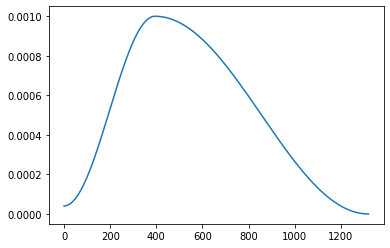

In [29]:
modelfiles = []

modelfiles.append(train_mri_type(df_train, df_valid, 'FLAIR'))

## Predict Function

In [30]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=8,
    )
   
    model = create_model()
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(cfg.device))).cpu().numpy().squeeze()
            print('tmp_pred', tmp_pred)
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

## Ensemble for validation

In [31]:
df_valid = df_valid.set_index("BraTS21ID")

Predict: /home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e13-loss0.691-auc0.635.pth FLAIR (61, 3)


/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tmp_pred [0.20538683 0.9714096  0.08439184 0.85764676 0.02867107 0.48457825
 0.6081684  0.8750083 ]
tmp_pred [0.03179292 0.9944435  0.0068042  0.92296636 0.5368448  0.93676764
 0.00923379 0.98603094]
tmp_pred [0.66226596 0.8253953  0.94973546 0.0018513  0.8724228  0.8575659
 0.8411833  0.1430309 ]
tmp_pred [0.27293274 0.80958825 0.91542584 0.94567233 0.92216015 0.8977027
 0.1491482  0.329766  ]
tmp_pred [0.8240062  0.3392947  0.1069571  0.75913674 0.08463106 0.4557307
 0.9483667  0.016974  ]
tmp_pred [9.6495551e-01 9.3880039e-01 6.9606077e-04 9.7024405e-01 4.8014799e-01
 8.7953526e-01 9.7112107e-01 8.0229968e-01]
tmp_pred [0.01095867 0.14775349 0.03960513 0.20737153 0.07884777 0.91480994
 0.98845726 0.01996204]
tmp_pred [0.99422956 0.07450246 0.92078567 0.9294468  0.12979539]
Validation ensemble AUC: 0.6353


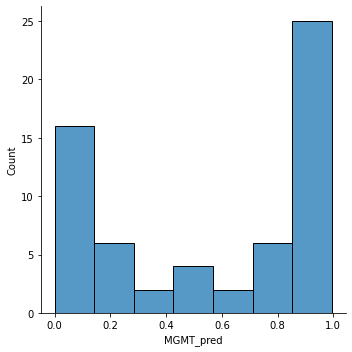

In [32]:
df_valid["MGMT_pred"] = 0
mri_types = ['FLAIR']
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])